<a href="https://colab.research.google.com/github/bc0403/ML2026/blob/main/lecture_02a_end_to_end_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# real-world example
Your task is to predict median house values in Californian districts, given a number of features from these districts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn.linear_model import LinearRegression


## Step 1, get the data

In [2]:
housing_path = "https://raw.githubusercontent.com/ageron/data/refs/heads/main/housing/housing.csv"
housing_full = pd.read_csv(housing_path)
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Step 2, EDA 1, quick glance
1. `head`
2. `info`
3. `value_counts` for categorical variables
3. `describe` and `hist` for numerical variables (operate on df)

In [3]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


the categorical feature should appy one-hot encoding

In [4]:
# for categorical variable
housing_full['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
# for numerical variable
housing_full.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


for numerical features, in the result of hist, we find:
1. `median_house_value` is the target, and it is much related to the `median_income` feature;
1. `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income` five features are skew right (NOT the normal distribution); [should apply log transform]
1. the unit of `median_income` is 10k USD;



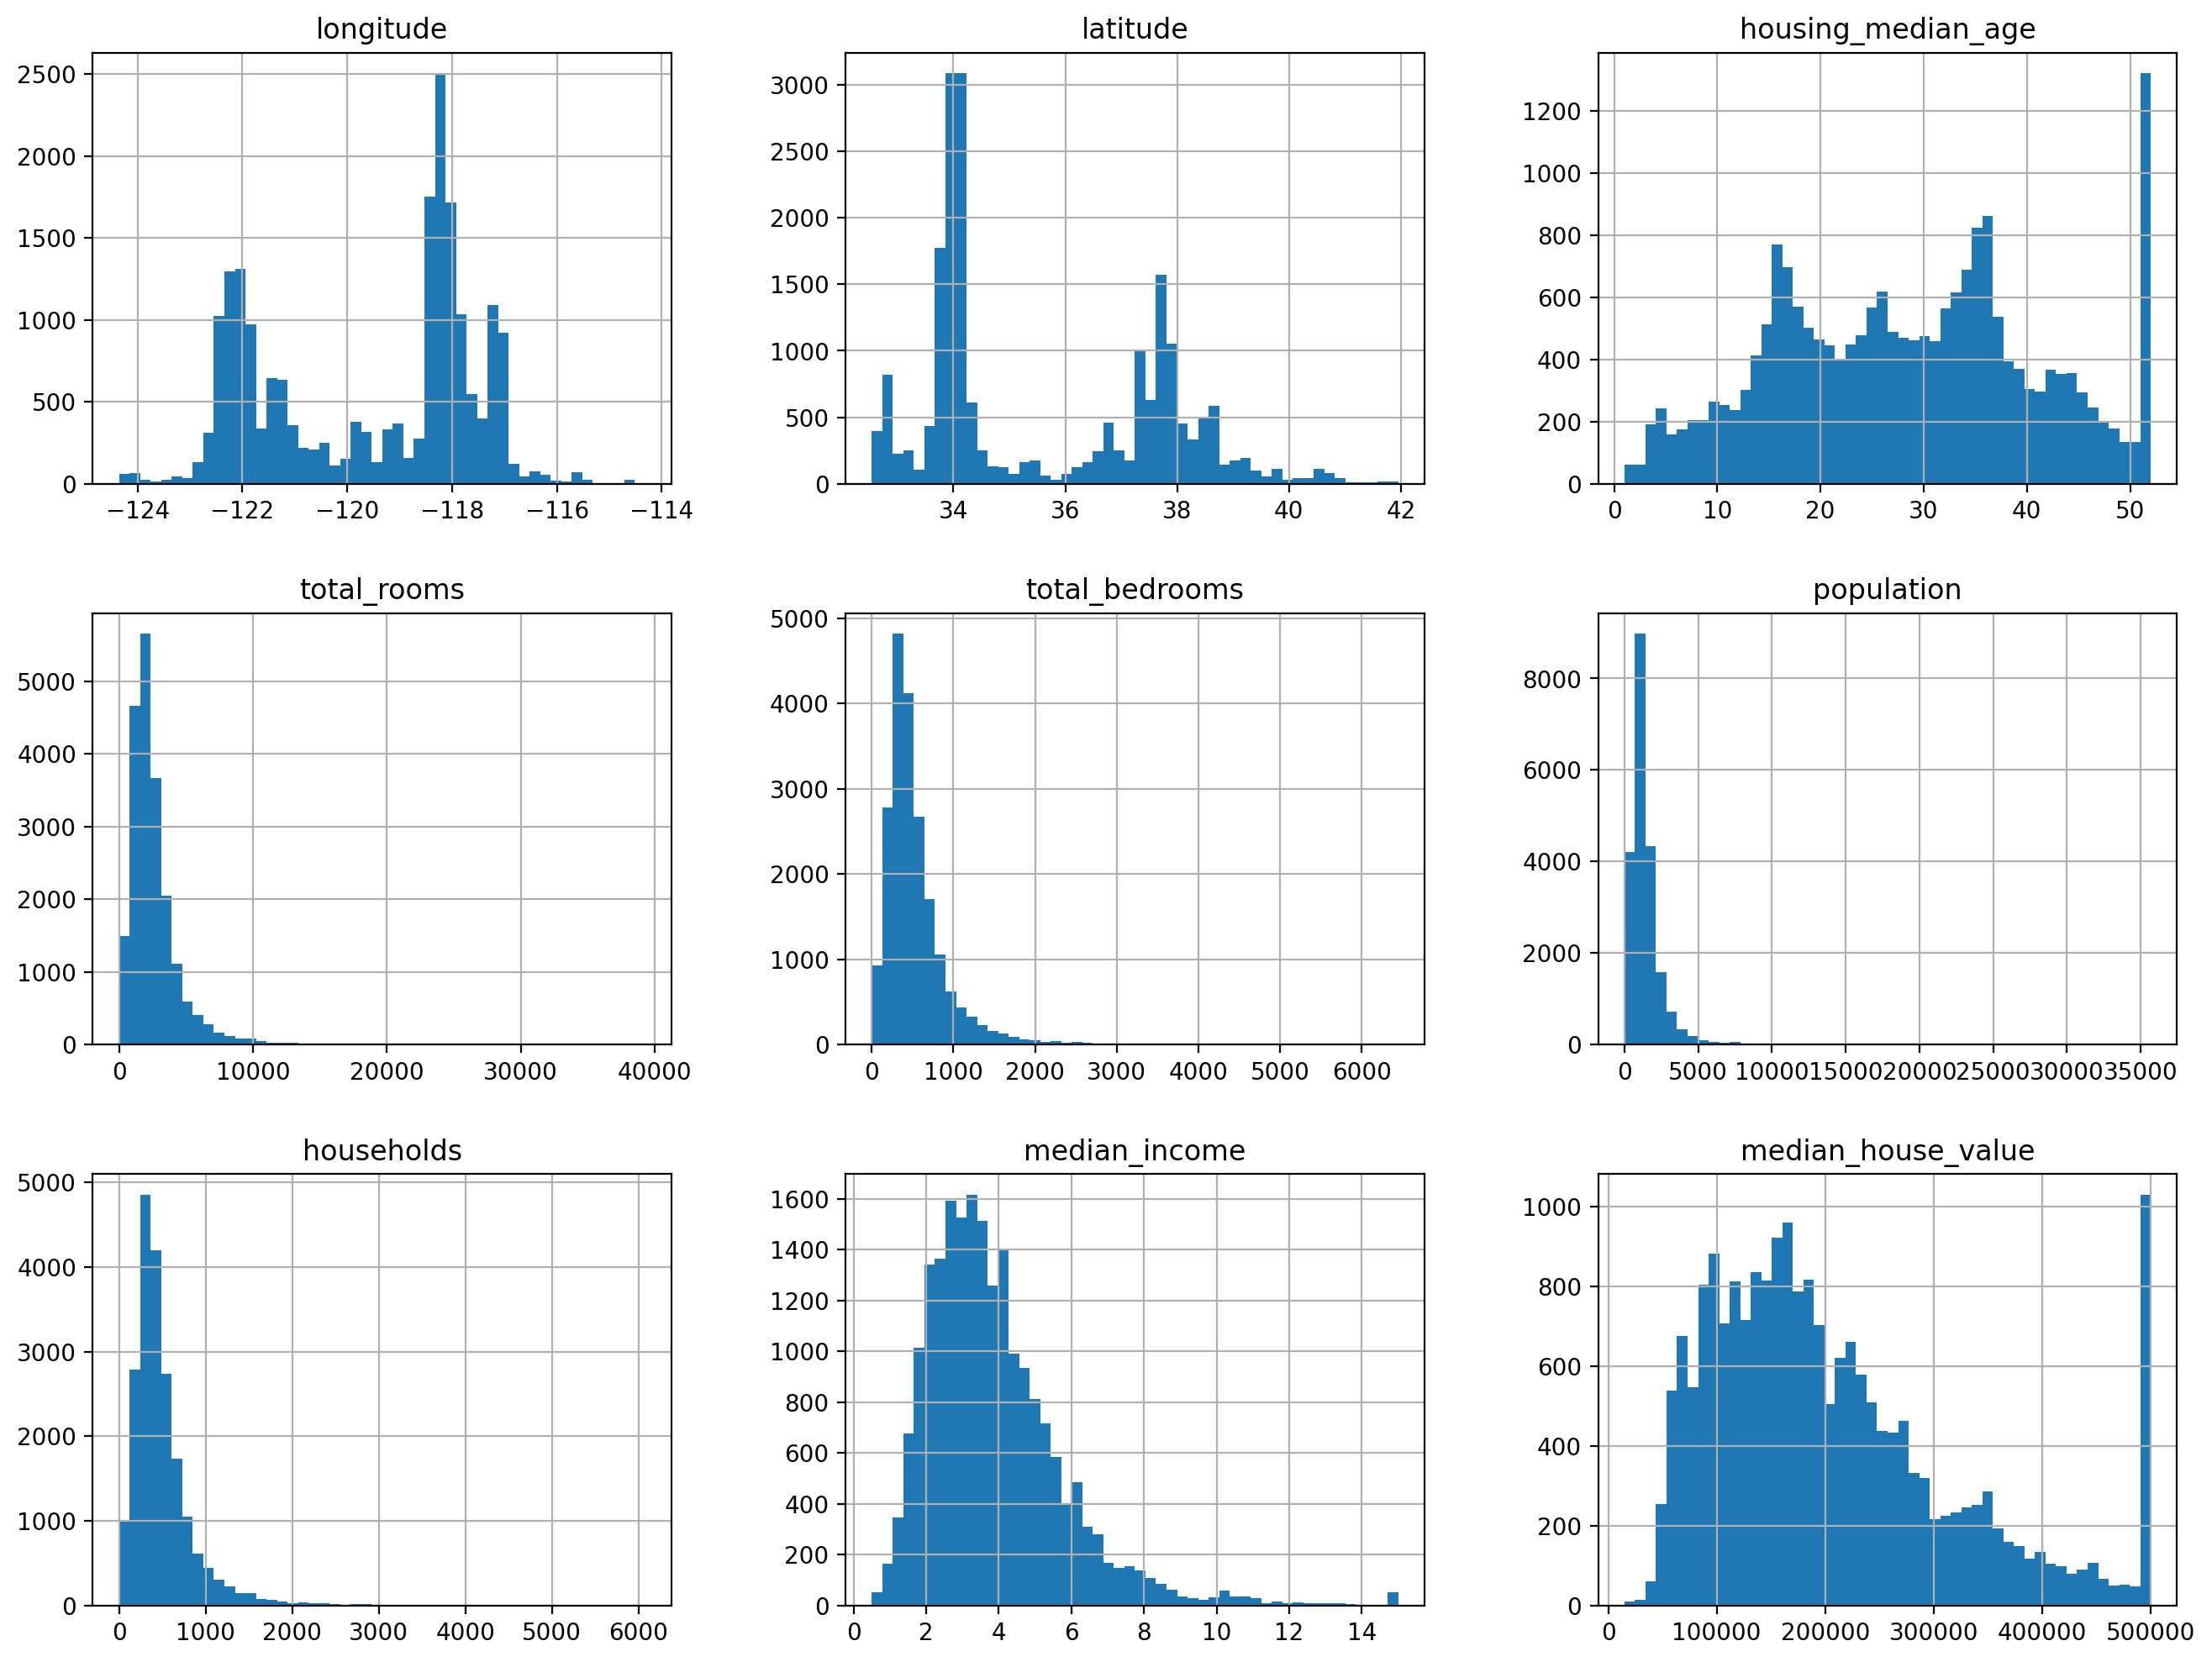

In [6]:
housing_full.hist(bins=50, figsize=(16,12))
plt.show()

## Step 3, split out the test set
- split out the test set by `stratified sampling`
- stratified by median_income feature (for regression, stratified by the most related feature; for classification, stratified by the target lables)

<Axes: xlabel='income_cat'>

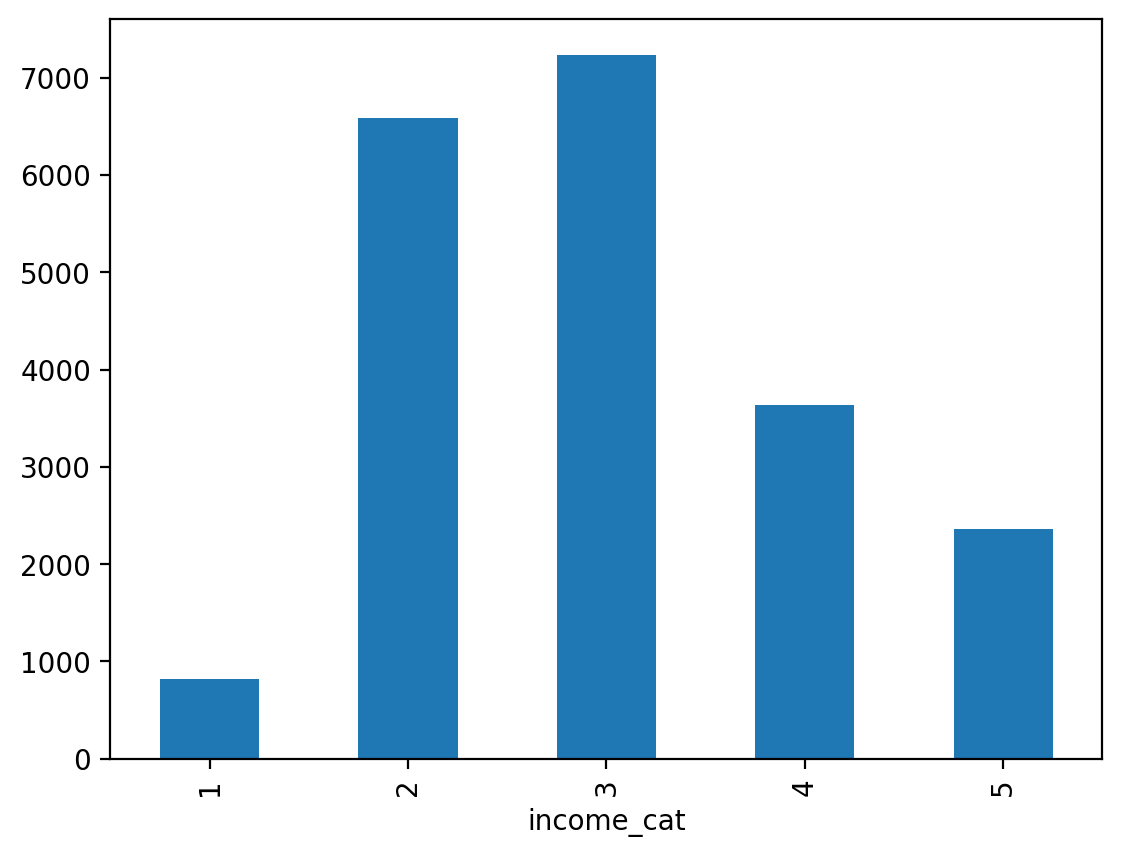

In [7]:
# create a categorical feature based on the most related numerical feature. ONLY for stratified sampling
housing_full['income_cat'] = pd.cut(housing_full['median_income'],
                                    bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])
cat_counts = housing_full['income_cat'].value_counts().sort_index()
cat_counts.plot.bar()

In [8]:
train_set, test_set = train_test_split(housing_full, test_size=0.2, stratify=housing_full['income_cat'], random_state=42)

print(test_set['income_cat'].value_counts() / len(test_set))
print(train_set['income_cat'].value_counts() / len(train_set))

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64
income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64


In [9]:
# now, the `income_cat` will never be used again
train_set.drop('income_cat', axis=1, inplace=True)  # `train_set` is the clean splitted train set
test_set.drop('income_cat', axis=1, inplace=True)  # `test_set` is the clean splitted test set

## Step 4, EDA 2, go depth on train set
- make a copy for exploration
- correlation, `corr` and `scatter_matrix`
- try combining attributes


<Axes: xlabel='longitude', ylabel='latitude'>

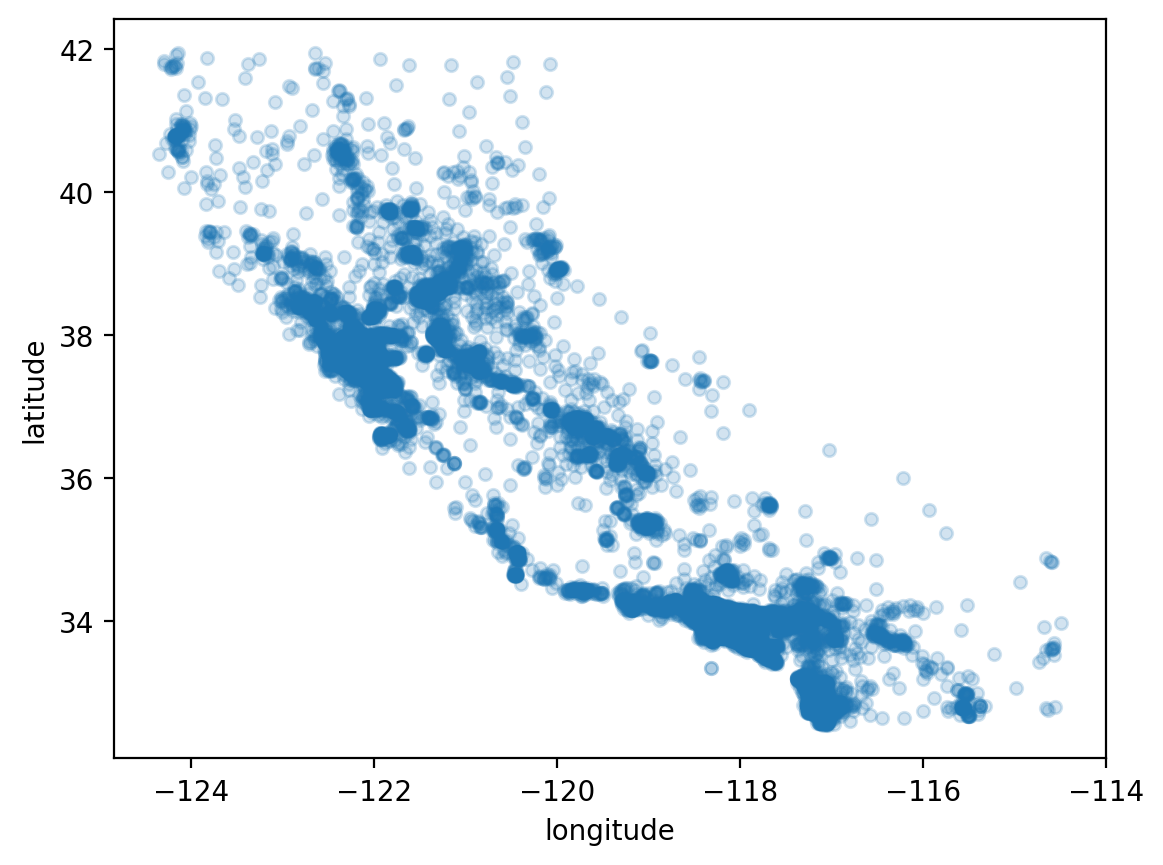

In [10]:
housing = train_set.copy()

housing.plot.scatter(x='longitude', y='latitude', alpha=0.2)

<Axes: xlabel='longitude', ylabel='latitude'>

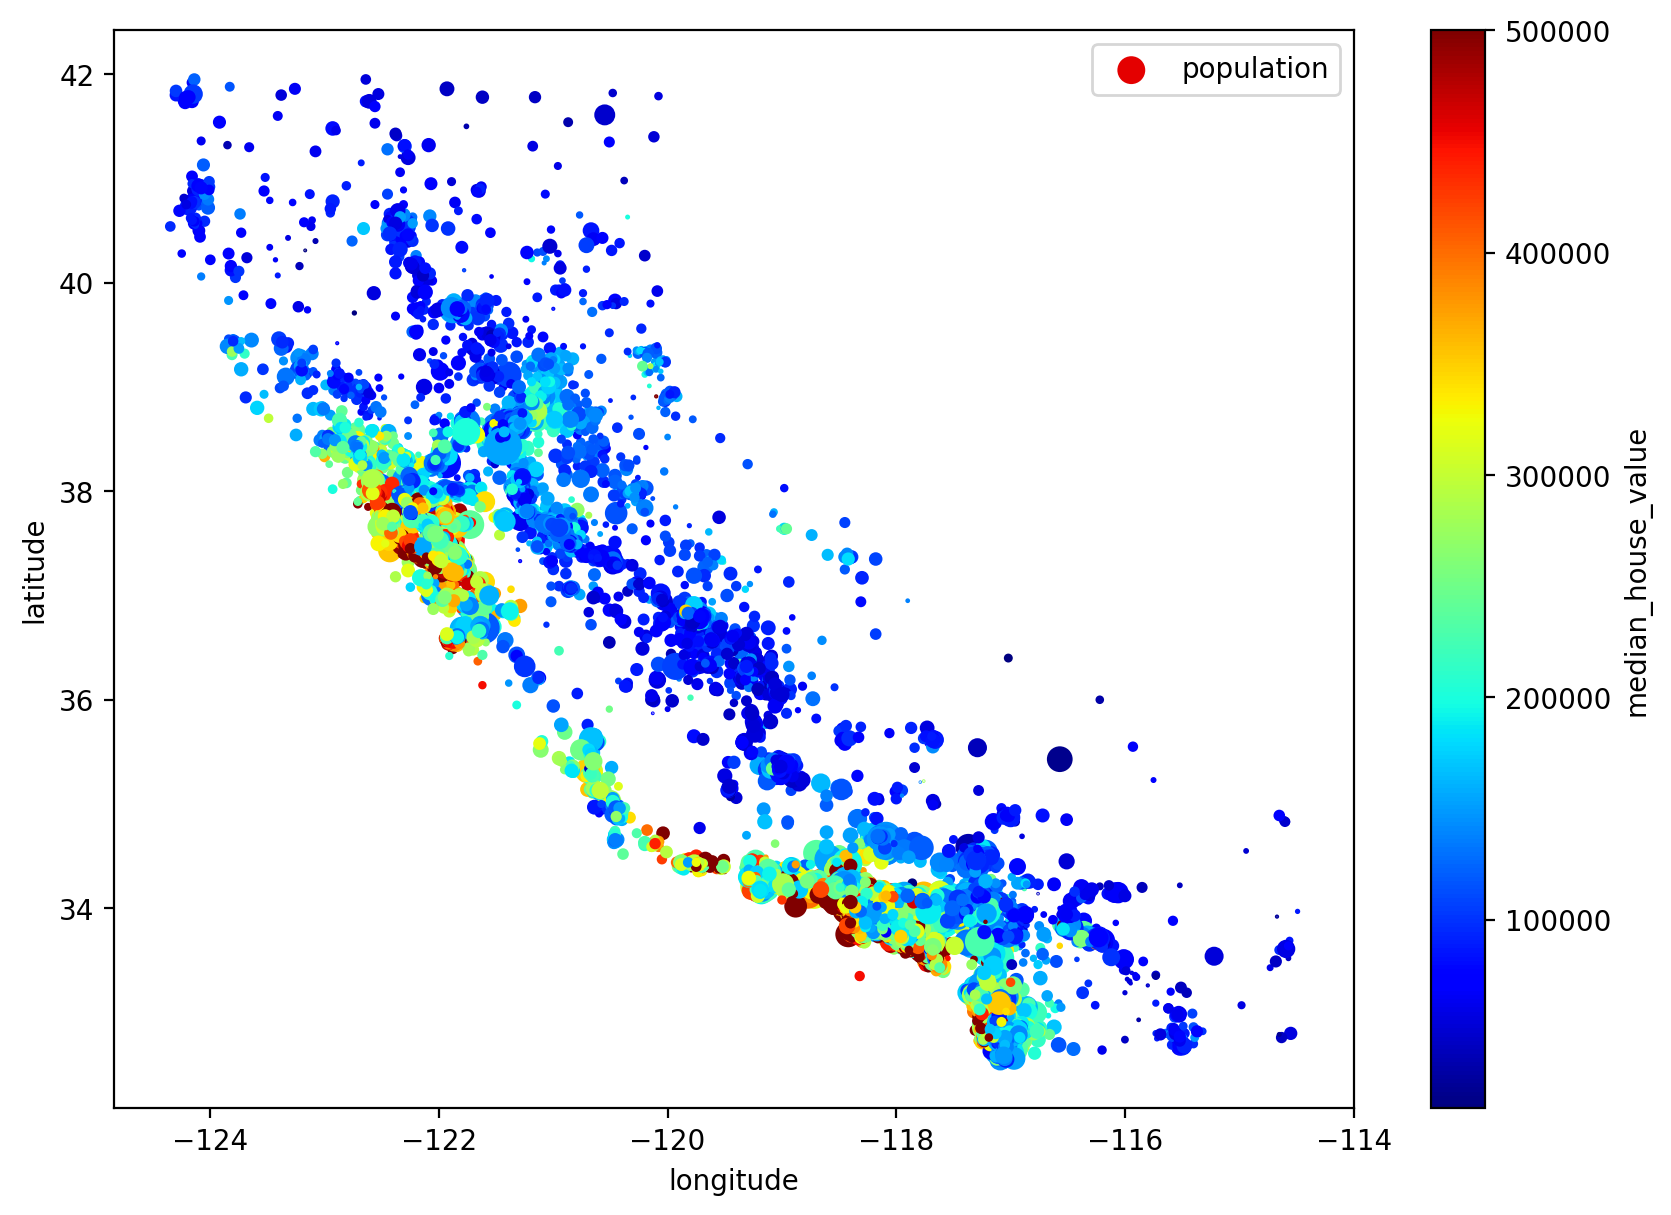

In [11]:
housing.plot.scatter(x='longitude', y='latitude', s=housing['population']/100,
                     label='population', figsize=(10,7),
                     c='median_house_value', cmap='jet', colorbar=True,
                     legend=True)

the most correlated feature is median_income, verified.

In [12]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


choose top four for plotting, and found that the median_income and the target are positive correlated

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

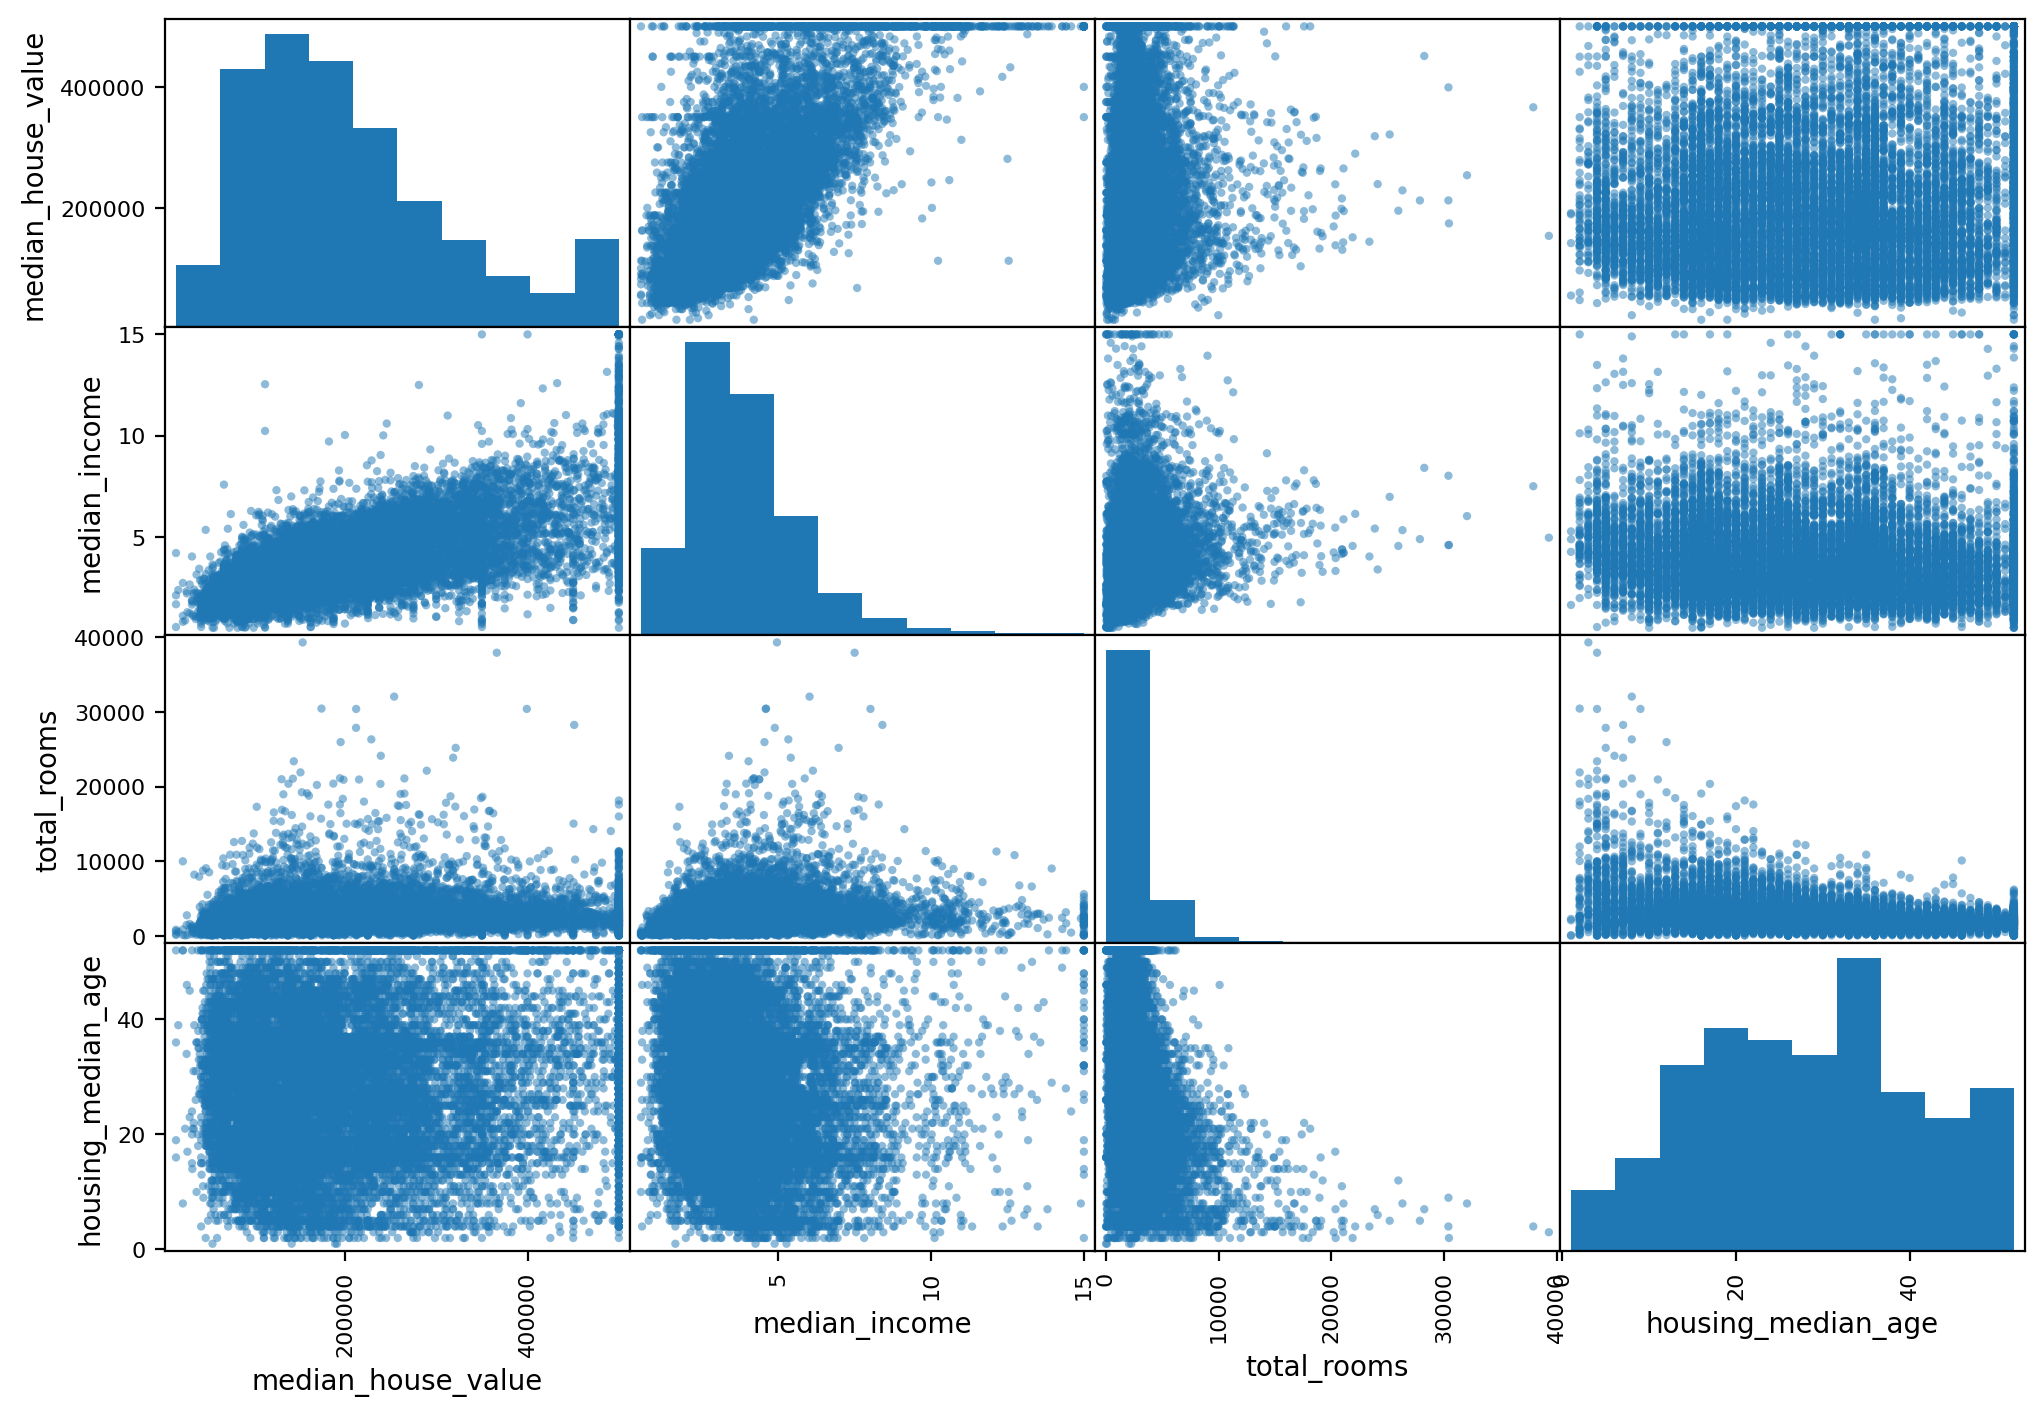

In [13]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))


<Axes: xlabel='median_income', ylabel='median_house_value'>

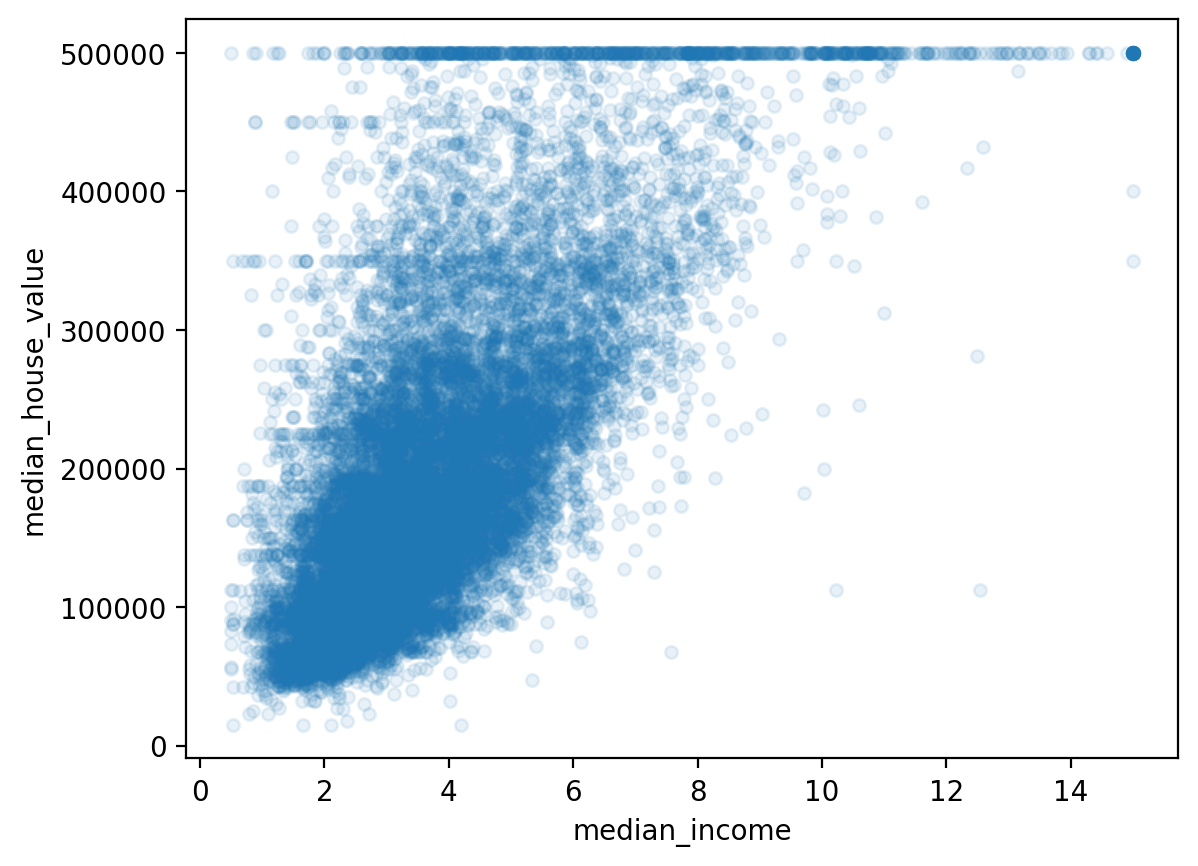

In [14]:
housing.plot.scatter(x='median_income', y='median_house_value', alpha=0.1)

calculte the ratio of two features may be more sensitive. Yes, the `bedrooms_ratio`, `rooms_per_house` are more meaningfual

In [15]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


the skewed feature can be tranformed by log

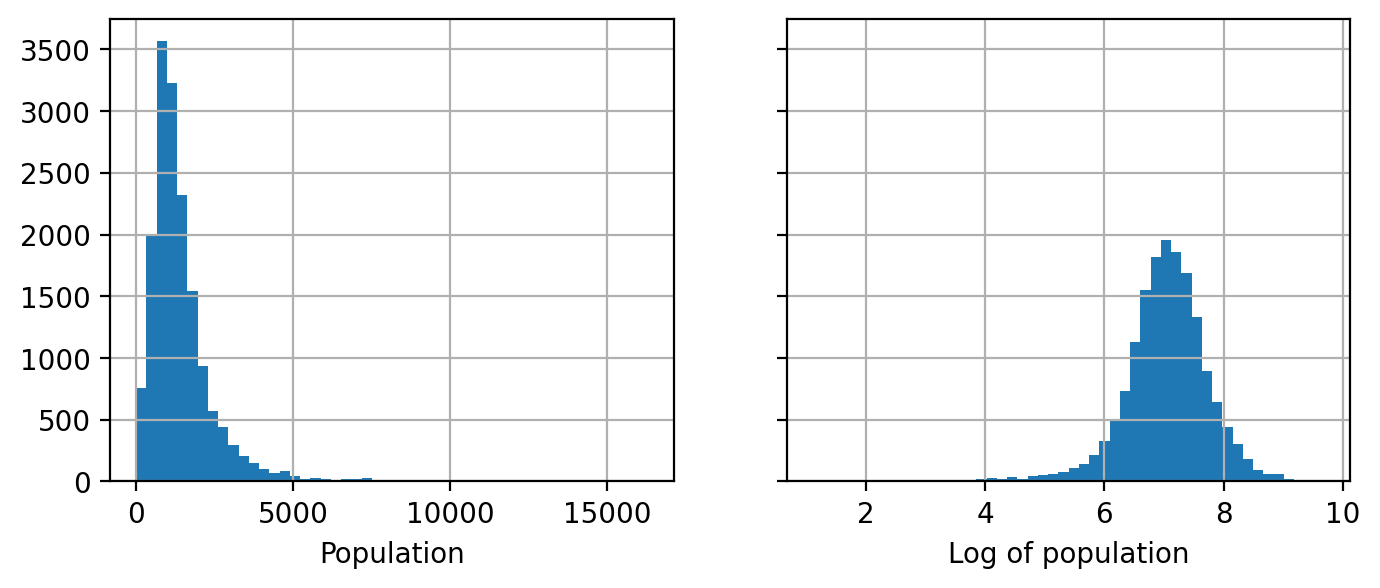

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")

plt.show()

In [17]:
# use rbf to calculate the similarity of location; use Kmeans to cluster the coordinates

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

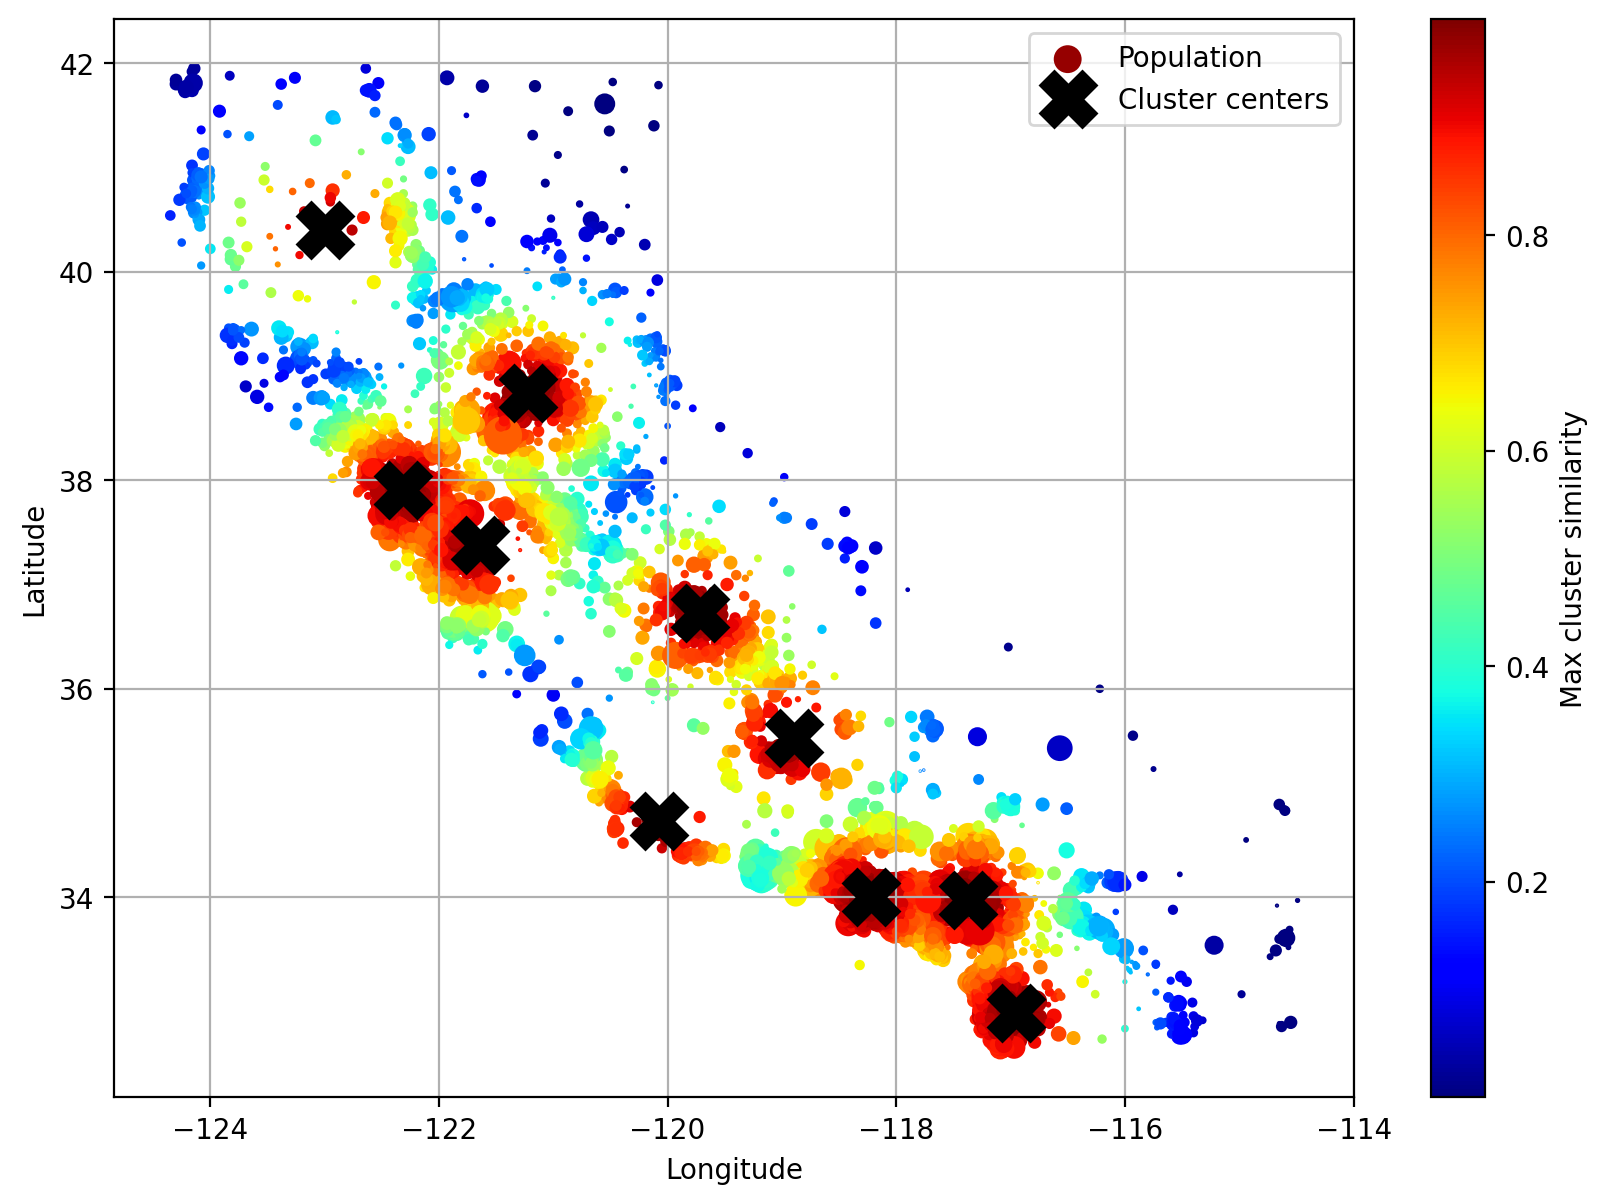

In [18]:
# extra code – this cell generates Figure 2–19

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

Summary:
1. skewed fetures need transformed by log
2. new ratio feature is needed
3. the distance similarity (rbf) can applied on the location
4. the categorical feature need one-hot encoding

## Step 5, prepare data
- handle missing values, numerical `SimpleImputer`;
- handle categorical feature, `OneHotEncoder`
- scale & transform

In [19]:
# start from original dataset before EDA2
housing = train_set.drop('median_house_value', axis=1)  # leave out the label; `drop` will return a new dataframe in default
housing_labels = train_set['median_house_value'].copy()  # df['xxx'] is view, so need .copy

customized transform

In [20]:
# pipeline 1, pipeline for numerical features
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

# pipeline 2, pipeline for categorical features
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [21]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

# pipeline 3, ratio pipeline
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

# pipeline 4, log pipeline
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

# pipeline 5, rbf similarity
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=num_pipeline)  # one column remaining: housing_median_age

In [22]:
housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared.shape)

(16512, 24)


In [23]:
preprocessing.get_feature_names_out()


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [24]:
housing_prepared_df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())

In [25]:
housing_prepared_df.head()


,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800


## Step 6, choose a model

### model 1, linear regression

In [26]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78e...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78e97caef830>)])),
                ('linearregression', LinearRegression())])

prediction, at a glance. can work

In [27]:
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(-2))  # -2 = rounded to the nearest hundred
print(housing_labels.iloc[:5].values)

[246000. 372700. 135700.  91400. 330900.]
[458300. 483800. 101700.  96100. 361800.]


In [28]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.3%, -23.0%, 33.4%, -4.9%, -8.5%


In [29]:
# performance, on total train set
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758484

### model 2, decision tree

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78e...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78e97caef830>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Fantastic!?

perfect performance since it fit and verify on the total train set. The true performance should verify on the validation or test set

In [31]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

### Bug fix, verify on validation set
decision tree is slightly better than linear regression

In [32]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [33]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,66573.734600
std,1103.402323
min,64607.896046
25%,66204.731788
50%,66388.272499
75%,66826.257468
max,68532.210664


In [34]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

,0
count,10.000000
mean,70003.404818
std,4182.188328
min,65504.765753
25%,68172.065831
50%,68743.995249
75%,70344.943988
max,81037.863741


### model 3, random forest


In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

performance improved!

In [36]:
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47038.092799
std,1021.491757
min,45495.976649
25%,46510.418013
50%,47118.719249
75%,47480.519175
max,49140.832210


observe the performance on train set and find that the performance on validation is still much poor than on train. This means it still has overfitting.

In [37]:
# performance on train set
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17551.2122500877

## Step 7, fine tune models


### Grid Search

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x78e97caef830>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [39]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

Let's look at the score of each hyperparameter combination tested during the grid search:

In [40]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42725,43708,44335,43590
13,15,8,43486,43820,44900,44069
6,10,4,43798,44036,44961,44265
9,10,6,43710,44163,44967,44280
7,10,6,43710,44163,44967,44280


### Randomized Search
preferred over grid search

In [41]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78e97aa81730>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78e97aa807d0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [42]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41342,42242,43057,42214
8,32,7,41825,42275,43241,42447
0,41,16,42238,42938,43354,42843
5,42,4,41869,43362,43664,42965
2,23,8,42490,42928,43718,43046


### Final model and top features


In [43]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
print(feature_importances.round(2))
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
       reverse=True)

[0.07 0.05 0.05 0.01 0.01 0.01 0.01 0.19 0.01 0.02 0.01 0.01 0.01 0.
 0.01 0.02 0.01 0.02 0.01 0.   0.01 0.02 0.01 0.01 0.01 0.   0.02 0.01
 0.01 0.   0.01 0.01 0.01 0.03 0.01 0.01 0.01 0.01 0.04 0.01 0.02 0.01
 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.07 0.
 0.   0.   0.01]


[(np.float64(0.18599734460509476), 'log__median_income'),
 (np.float64(0.07338850855844489), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06556941990883976), 'bedrooms__ratio'),
 (np.float64(0.053648710076725316), 'rooms_per_house__ratio'),
 (np.float64(0.04598870861894749), 'people_per_house__ratio'),
 (np.float64(0.04175269214442519), 'geo__Cluster 30 similarity'),
 (np.float64(0.025976797232869678), 'geo__Cluster 25 similarity'),
 (np.float64(0.023595895886342255), 'geo__Cluster 36 similarity'),
 (np.float64(0.02021056221732893), 'geo__Cluster 9 similarity'),
 (np.float64(0.01860691707666145), 'geo__Cluster 34 similarity'),
 (np.float64(0.018137988374628867), 'geo__Cluster 37 similarity'),
 (np.float64(0.01740435316632675), 'geo__Cluster 18 similarity'),
 (np.float64(0.016778386143844894), 'geo__Cluster 1 similarity'),
 (np.float64(0.015459009666188978), 'geo__Cluster 7 similarity'),
 (np.float64(0.015325731028175924), 'geo__Cluster 32 similarity'),
 (np.float64(0.0150737720150383

## Step 8, evaluate on test set
the performance on test set is similar on validation set

In [44]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41445.533268606625


In [45]:
# 95% confidence interval
from scipy.stats import bootstrap

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = bootstrap([squared_errors], rmse, confidence_level=confidence,
                        random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval
print(rmse_lower, rmse_upper)

39520.95719181788 43701.76812180527


## Step 9, save the model


In [46]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

## Step 10, deploy and using the model

In [47]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
print(predictions)
print(housing_labels.iloc[:5].values)
error_ratios = predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

[441046.12 454713.09 104832.   101316.   336181.05]
[458300. 483800. 101700.  96100. 361800.]
-3.8%, -6.0%, 3.0%, 5.4%, -7.1%
